In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import scipy

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [5]:
expression_fp = '/data/stemness/ERP016000/counts.tsv'
metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [8]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.hd5'), 'df')
expression_df.index = [c.split('_')[-1] for c in expression_df.index]
expression_df = expression_df.transpose()
expression_df

,TSPAN6,DPM1,SCYL3,C1orf112,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,...,LUC7L2,ZNF559-ZNF177,HSPE1-MOB4,RPS10-NUDT3,SRGAP2D,MTRNR2L2,SRXN1,GTF2H5,NUDT3,CD24
21843_1#10,5.520777,5.392461,0.000174,1.471928,2.908802,0.127185,0.000000,3.615650,0.000000,5.604953,...,0.575989,0.290480,3.342019,2.955039,0.286690,8.993125,0.000000,1.397666,0.716015,2.578313
21843_1#100,6.456208,6.065923,0.352597,4.536968,3.867327,0.047614,4.277551,0.000000,0.000000,5.848853,...,1.379352,0.000000,2.642681,0.315327,0.446590,10.310311,0.000000,1.399811,1.857059,0.000000
21843_1#101,5.878671,6.838769,0.000000,4.318528,3.321747,4.042388,0.000000,2.545334,0.185345,5.196831,...,3.051514,0.000000,3.053322,1.082602,0.000000,10.112632,0.390075,2.421133,2.499615,0.889010
21843_1#102,4.860824,6.614268,0.825955,5.373009,3.736476,2.662104,1.115943,0.000000,0.000000,3.811312,...,2.453614,0.000000,2.503949,2.271033,0.000000,9.380978,0.000000,2.250520,2.615108,1.963302
21843_1#103,5.903640,6.512403,2.201697,4.636175,4.917576,2.499359,2.278948,2.672572,0.243054,4.964217,...,1.613052,0.000000,2.471723,0.218927,0.000000,9.511378,0.000000,2.633359,1.682406,1.412966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,6.199875,5.885993,0.000000,3.227508,4.221847,0.000000,4.137042,1.758011,0.000000,5.039266,...,1.130735,1.937917,1.906042,1.143744,0.000000,1.709041,0.000000,3.208027,2.139444,7.552773
24539_8#94,7.014180,7.431358,0.108025,2.621121,3.188030,1.393474,3.378998,3.703450,0.139112,4.209373,...,0.403450,1.756385,5.584232,1.768525,0.410279,7.568684,0.000000,4.137374,0.852408,7.631217
24539_8#95,6.228476,7.013124,1.756339,3.950978,4.741496,2.465067,3.069041,2.829073,4.306653,5.019318,...,0.474118,0.279475,5.136851,0.203189,1.306076,6.345048,0.284224,1.847985,1.091890,7.109529
24539_8#97,6.217161,4.851771,2.492943,3.926914,3.872743,3.189254,2.178870,1.834021,0.000000,4.075990,...,1.440802,2.394519,3.511525,1.622543,0.000000,7.577899,0.000000,2.144427,2.796956,7.185068


In [9]:
metadata_df = pd.read_csv(metadata_fp, sep='\t')
metadata_df = metadata_df.loc[expression_df.index]
metadata_df = metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
metadata_df

,assigned,cell_name,day,donor_long_id,donor_short_id,experiment,total_counts,total_counts_MT,pseudo,sample_id,well_id,well_type
21843_1#10,1,21843_1#10,day1,HPSI0114i-joxm_1,joxm_1,expt_09,598658.209173,45560.066753,0.292682,21843_1#10,A10,single cell
21843_1#100,1,21843_1#100,day1,HPSI0314i-fafq_1,fafq_1,expt_09,222558.809077,26617.964539,0.484716,21843_1#100,E04,single cell
21843_1#101,1,21843_1#101,day1,HPSI0314i-fafq_1,fafq_1,expt_09,582661.572985,55173.613380,0.403809,21843_1#101,E05,single cell
21843_1#102,1,21843_1#102,day1,HPSI1013i-wuye_2,wuye_2,expt_09,476557.701340,37076.110494,0.260772,21843_1#102,E06,single cell
21843_1#103,1,21843_1#103,day1,HPSI0114i-joxm_1,joxm_1,expt_09,404342.711311,28949.266469,0.355366,21843_1#103,E07,single cell
...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,1,24539_8#93,day1,HPSI0713i-nocf_2,nocf_2,expt_35,347580.461936,31633.724898,0.199677,24539_8#93,D21,single cell
24539_8#94,1,24539_8#94,day1,HPSI1013i-zagm_1,zagm_1,expt_35,395735.359197,56999.061471,0.251769,24539_8#94,D22,single cell
24539_8#95,1,24539_8#95,day1,HPSI0314i-wigw_2,wigw_2,expt_35,474715.299368,37026.549761,0.226935,24539_8#95,D23,single cell
24539_8#97,1,24539_8#97,day1,HPSI1113i-wahn_1,wahn_1,expt_35,75472.999850,4251.880902,0.389748,24539_8#97,E01,single cell


In [10]:
stem_adata = anndata.AnnData(X=expression_df.values, obs=metadata_df)
stem_adata.obs.index = expression_df.index
stem_adata.var.index = expression_df.columns
stem_adata

AnnData object with n_obs × n_vars = 36044 × 11231 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'

In [11]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [12]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [14]:
tumor_adata = anndata.AnnData(X=expression_df.values, obs=label_df)
tumor_adata.obs.index = expression_df.index
tumor_adata.var.index = expression_df.columns
tumor_adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [15]:
## get rid of unknowns
tumor_adata = tumor_adata[tumor_adata.obs[cell_type_key]!='Unknown']
tumor_adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


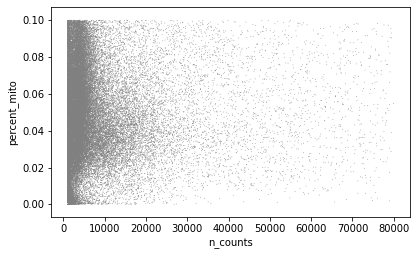

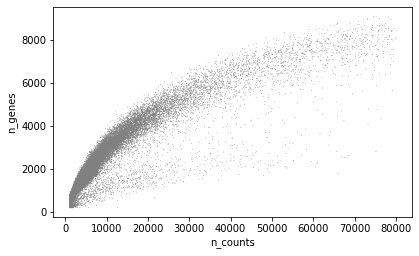

In [16]:
sc.pp.filter_cells(tumor_adata, min_genes=200)
sc.pp.filter_genes(tumor_adata, min_cells=3)

mito_genes = tumor_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
tumor_adata.obs['percent_mito'] = np.sum(
    tumor_adata[:, mito_genes].X, axis=1) / np.sum(tumor_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
tumor_adata.obs['n_counts'] = tumor_adata.X.sum(axis=1)

sc.pl.scatter(tumor_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(tumor_adata, x='n_counts', y='n_genes')

In [17]:
## stem dataset is cpm then logged so do the same thing here
sc.pp.normalize_total(tumor_adata, target_sum=1e6)
sc.pp.log1p(tumor_adata)
tumor_adata.raw = tumor_adata
tumor_adata

AnnData object with n_obs × n_vars = 48280 × 26912 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [22]:
stem_adata.raw = stem_adata

In [ ]:
## bring in the stem dataset

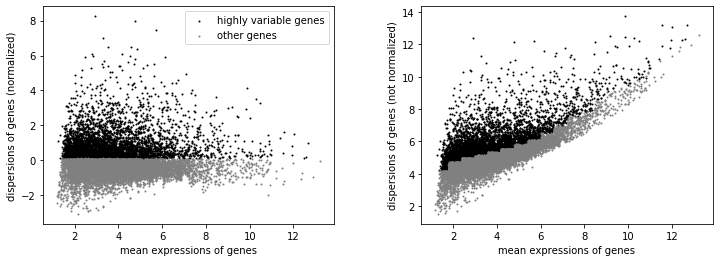

In [21]:
sc.pp.highly_variable_genes(stem_adata, min_mean=0.0, max_mean=15., min_disp=0.1)
sc.pl.highly_variable_genes(stem_adata)

In [23]:
np.count_nonzero(stem_adata.var.highly_variable)

4134

In [24]:
adata = stem_adata.concatenate(tumor_adata)
adata

AnnData object with n_obs × n_vars = 84324 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

In [26]:
# adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=None)
adata

AnnData object with n_obs × n_vars = 84324 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

In [27]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(p

In [31]:
adata.obs['dataset'] = ['stem' if pd.isnull(x) else 'tumor' for x in adata.obs['cell_type']]

In [80]:
n = 2500

stem_idxs = np.asarray(adata.obs.index)[adata.obs['dataset']=='stem']
np.random.shuffle(stem_idxs)

stem_train_idxs = stem_idxs[:n]
stem_val_idxs = stem_idxs[n:]

stem_train_idxs.shape, stem_val_idxs.shape

((2500,), (33544,))

In [81]:
import random
## filter smartly
n = 2500

ta = adata[adata.obs['cell_type']=='BR_Malignant']


cell_type_to_idxs = {}
for cell_id, cell_type in zip(ta.obs.index, ta.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

tumor_train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
tumor_train_idxs = np.arange(ta.shape[0])[np.isin(np.asarray(ta.obs.index), tumor_train_idxs)]
tumor_val_idxs = np.delete(np.arange(ta.shape[0]), tumor_train_idxs)

tumor_train_idxs = np.asarray([ta.obs.index[i] for i in tumor_train_idxs])
tumor_val_idxs = np.asarray([ta.obs.index[i] for i in tumor_val_idxs])


tumor_train_idxs.shape, tumor_val_idxs.shape

((2500,), (7637,))

In [82]:
train_idxs = np.concatenate((stem_train_idxs, tumor_train_idxs))
np.random.shuffle(train_idxs)

val_idxs = np.concatenate((stem_val_idxs, tumor_val_idxs))
np.random.shuffle(val_idxs)

train_idxs.shape, val_idxs.shape

((5000,), (41181,))

In [83]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [84]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((5000, 10520), (41181, 10520))

In [85]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [86]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [87]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [88]:
epochs = 100
latent_dim = 100
alpha = 0.1

model = BVAE(latent_dim, X_train.shape[1])

In [89]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')

epoch: 1, val loss: 217.95590209960938
epoch: 2, val loss: 208.47738647460938
epoch: 3, val loss: 201.5157928466797
epoch: 4, val loss: 196.87881469726562
epoch: 5, val loss: 196.16329956054688
epoch: 6, val loss: 196.31011962890625
epoch: 7, val loss: 192.68788146972656
epoch: 8, val loss: 191.7571563720703
epoch: 9, val loss: 190.07940673828125
epoch: 10, val loss: 189.27597045898438
epoch: 11, val loss: 187.36398315429688
epoch: 12, val loss: 186.23501586914062
epoch: 13, val loss: 186.24444580078125
epoch: 14, val loss: 185.97207641601562
epoch: 15, val loss: 184.13323974609375
epoch: 16, val loss: 184.11526489257812
epoch: 17, val loss: 182.6964874267578
epoch: 18, val loss: 182.5406494140625
epoch: 19, val loss: 182.8607635498047
epoch: 20, val loss: 182.6846160888672
epoch: 21, val loss: 181.517822265625
epoch: 22, val loss: 181.99209594726562
epoch: 23, val loss: 181.55001831054688
epoch: 24, val loss: 180.5343780517578
epoch: 25, val loss: 180.2262420654297
epoch: 26, val loss

KeyboardInterrupt: 

In [90]:
p_adata = train_adata.concatenate(val_adata)
p_adata

AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'

In [91]:
cell_embeddings = None
step = 1000
for i in range(0, p_adata.shape[0], step):
    batch = p_adata[i:i+step]
    
    mean, logvar = model.encode(batch.X)
    if cell_embeddings is None:
        cell_embeddings = model.reparameterize(mean, logvar).numpy()
    else:
        cell_embeddings = np.concatenate((cell_embeddings, model.reparameterize(mean, logvar).numpy()),
                                         axis=0)

cell_embeddings.shape

(46181, 100)

In [92]:
p_adata.obsm['cell_embeddings'] = cell_embeddings
p_adata

AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'

In [93]:
p_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(p_adata.obsm['cell_embeddings'])
p_adata.obs['cell_embedding_umap1'] = p_adata.obsm['cell_embedding_umap'][:, 0]
p_adata.obs['cell_embedding_umap2'] = p_adata.obsm['cell_embedding_umap'][:, 1]

p_adata

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


AnnData object with n_obs × n_vars = 46181 × 10520 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'

... storing 'cell_name' as categorical
... storing 'donor_long_id' as categorical
... storing 'donor_short_id' as categorical
... storing 'sample_id' as categorical
... storing 'well_id' as categorical


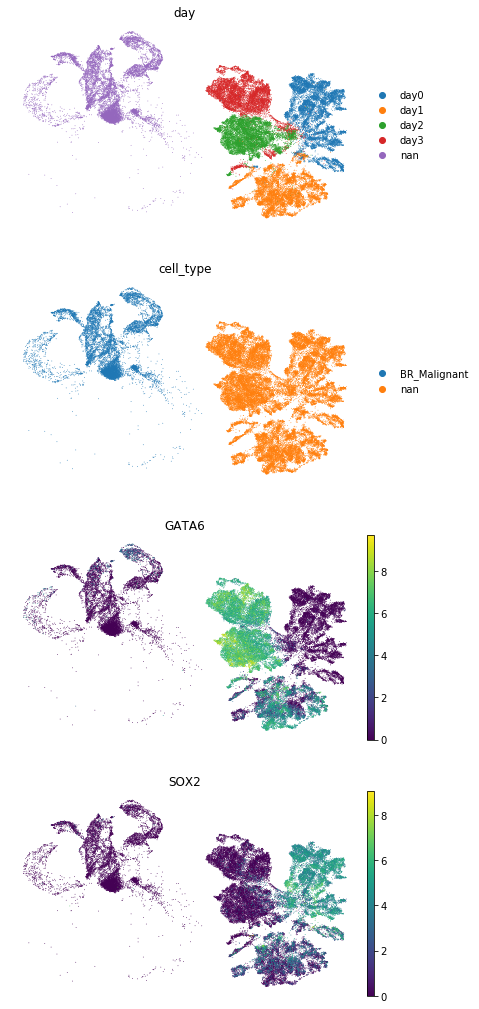

In [94]:
sc.pl.umap(p_adata, color=['day', 'cell_type', 'GATA6', 'SOX2'], frameon=False, ncols=1, )

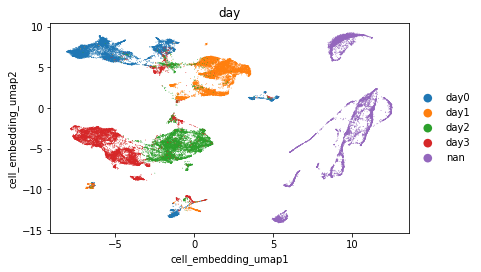

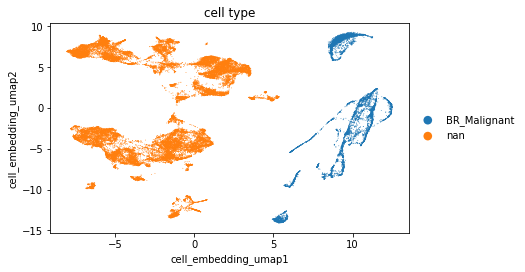

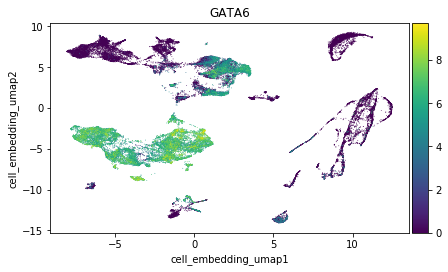

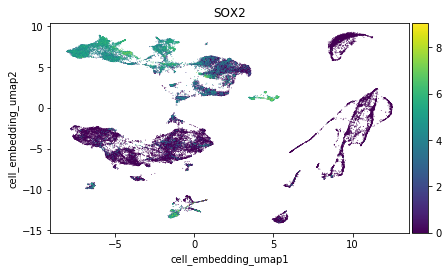

In [95]:
variables = ['day', 'cell_type', 'GATA6', 'SOX2']
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [96]:
gene = 'SOX2'
idx = list(p_adata.var.index).index(gene)
gene, idx

('SOX2', 8782)

In [105]:

tups = []
for i in range(p_adata.obsm['cell_embeddings'].shape[1]):
    position_vals = p_adata.obsm['cell_embeddings'][:, i].flatten()
    gene_vals = p_adata[:, gene].X.flatten()
    
    xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, p_adata.obs['dataset'])
                                            if t == 'stem'])
    correlation = scipy.stats.pearsonr(xs, ys)
    r = correlation[0]
    tups.append((i, r))
    
    p_adata.obs[f'position_{i}'] = position_vals
tups = sorted(tups, key=lambda x: x[1])
tups[:10], tups[-10:]

([(49, -0.6393401730541838),
  (27, -0.5326752806373644),
  (63, -0.5200192077825057),
  (19, -0.47239652757448963),
  (3, -0.45819097053104396),
  (13, -0.4565066064922854),
  (31, -0.45614226504170746),
  (47, -0.34411391836190186),
  (85, -0.34345930696296595),
  (86, -0.33432642224841275)],
 [(23, 0.2983222884828151),
  (67, 0.3009247383761397),
  (30, 0.3055619989966893),
  (50, 0.3207448783915529),
  (71, 0.3523728384161534),
  (32, 0.3711107644385676),
  (93, 0.37245795455746067),
  (62, 0.37973653374000843),
  (21, 0.6298681623092977),
  (52, 0.7325221384933662)])

In [113]:
p_adata.obs['sample_name'] = ['stem' if d == 'stem' else s
                              for d, s in zip(p_adata.obs['dataset'], p_adata.obs['sample_id'])]
set(p_adata.obs['sample_name'])

{'TWCE-HT062B1-S1PAA1A1Z1B1',
 'TWCE-HT062B1-S1PBA1A1Z1B1',
 'TWCE-HT062B1-S1R1A1Z1B1',
 'TWCE-HT065B1-S1H1A2A1Z1B1',
 'TWCE-HT065B1-S1H7A2A1Z1B1',
 'TWCE-HT067B1-S1H2A2A1Z1B1',
 'TWCE-HT067B1-S1H5A2A1Z1B1',
 'TWCE-HT068B1-S1H1A2A1Z1B1',
 'TWCE-HT068B1-S1H2A2A1Z1B1',
 'TWCE-HT077B1-XB1',
 'TWCE-HT077B1-XB2',
 'TWCE-HT077B1-XB3',
 'TWCE-HT084B1-XB1',
 'TWCE-HT103B1-XB1',
 'TWCE-HT103B1-XB2',
 'TWCE-HT105B1-XB1',
 'TWCE-HT105B1-XB2',
 'TWCE-HT105B1-XB3',
 'TWCE-HT110B1-XB1',
 'TWCE-HT110B1-XB2',
 'TWCE-HT110B1-XB3',
 'stem'}

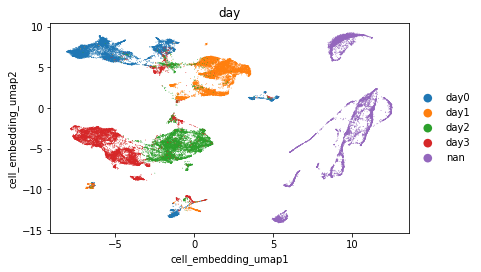

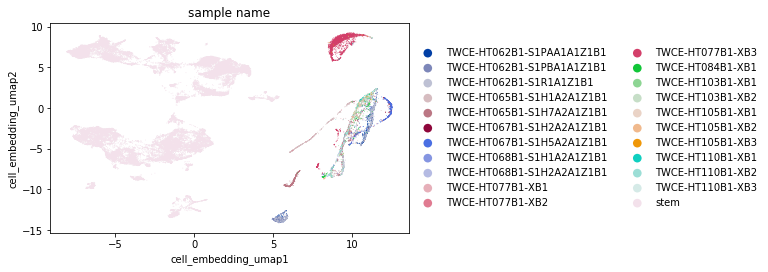

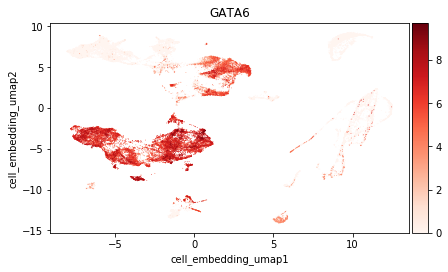

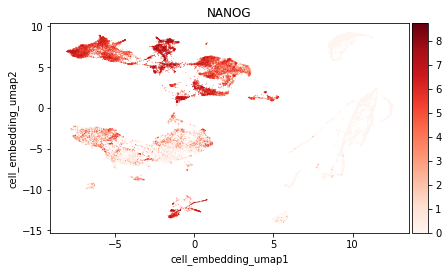

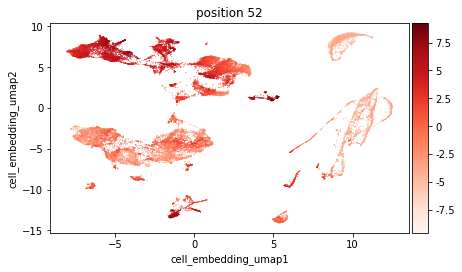

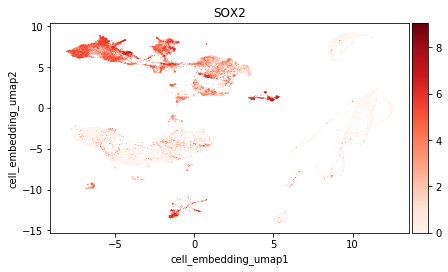

In [115]:
variables = ['day', 'sample_name', 'GATA6', 'NANOG', 'position_52', 'SOX2']
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()